In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os
import pandas as pd

# import problems to solve
import problems
import experiments
import train
import topo_api
import topo_physics
import models
import utils

from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from scipy.ndimage import gaussian_filter

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
def constrained_structural_optimization_function(model, ke, args, designs, losses):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )
    x_phys = torch.sigmoid(logits)

    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)

    # Calculate the u_matrix
    u_matrix, _ = topo_physics.sparse_displace(
        x_phys, ke, args, forces, args["freedofs"], args["fixdofs"], **kwargs
    )

    # Calculate the compliance output
    compliance_output, _, _ = topo_physics.compliance(x_phys, u_matrix, ke, args, **kwargs)

    # The loss is the sum of the compliance
    f = torch.abs(torch.sum(compliance_output))

    # Run this problem with no inequality constraints
    ci = None

    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = 5e3 * (torch.mean(x_phys) - args['volfrac'])

    # Append updated physical density designs
    designs.append(
        x_phys
    )  # noqa

    return f, ci, ce

In [5]:
# Identify the problem
problem = problems.mbb_beam(height=20, width=60)
problem.name = 'mbb_beam'

# cnn_kwargs
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

# Get the problem args
args = topo_api.specified_task(problem)

# Trials
trials = []

for seed in range(40, 42):
    torch.random.manual_seed(seed)

    # Initialize the CNN Model
    if cnn_kwargs is not None:
        cnn_model = models.CNNModel(args, **cnn_kwargs)
    else:
        cnn_model = models.CNNModel(args)

    # Put the cnn model in training mode
    cnn_model.train()

    # Create the stiffness matrix
    ke = topo_physics.get_stiffness_matrix(
        young=args["young"],
        poisson=args["poisson"],
    )

    # Create the combined function and structural optimization
    # setup
    # Save the physical density designs & the losses
    designs = []
    losses = []
    # Combined function
    comb_fn = lambda model: constrained_structural_optimization_function(  # noqa
        model, ke, args, designs, losses
    )

    # Initalize the pygranso options
    opts = pygransoStruct()

    # Set the device
    opts.torch_device = torch.device('cpu')

    # Setup the intitial inputs for the solver
    nvar = getNvarTorch(cnn_model.parameters())
    opts.x0 = (
        torch.nn.utils.parameters_to_vector(cnn_model.parameters())
        .detach()
        .reshape(nvar, 1)
    )

    # Additional pygranso options
    opts.limited_mem_size = 20
    opts.double_precision = True
    opts.mu0 = 1.0
    opts.maxit = 500
    opts.print_frequency = 10
    opts.stat_l2_model = False
    opts.viol_eq_tol = 1e-6
    opts.opt_tol = 1e-6
    
    mHLF_obj = utils.HaltLog()
    halt_log_fn, get_log_fn = mHLF_obj.makeHaltLogFunctions(opts.maxit)

    #  Set PyGRANSO's logging function in opts
    opts.halt_log_fn = halt_log_fn

    # Main algorithm with logging enabled.
    soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)

    # GET THE HISTORY OF ITERATES
    # Even if an error is thrown, the log generated until the error can be
    # obtained by calling get_log_fn()
    log = get_log_fn()
    
    # Final structure
    designs_indexes = (pd.Series(log.fn_evals).cumsum() - 1).values.tolist()
    final_designs = [designs[i] for i in designs_indexes]
    
    trials.append((soln.final.f, pd.Series(log.f), final_designs))

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:70: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:71: UserWarning: __floordiv__ is deprecated, and its behavior will change



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

/Users/ryandevera/.pyenv/versions/3.9.11/lib/python3.9/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


  10 ║ 0.348678 │  112.258927196 ║  320.683119784 ║   -  │ 0.443637 ║ S  │     1 │ 1.000000 ║     1 │ 0.042182   ║ 
  20 ║ 0.254187 │  63.4029947648 ║  242.976052112 ║   -  │ 1.641742 ║ S  │     1 │ 1.000000 ║     1 │ 0.041764   ║ 
  30 ║ 0.254187 │  56.8340829138 ║  220.370725683 ║   -  │ 0.818801 ║ S  │     1 │ 1.000000 ║     1 │ 0.133752   ║ 
  40 ║ 0.254187 │  53.0422726308 ║  206.624246518 ║   -  │ 0.521161 ║ S  │     2 │ 0.500000 ║     1 │ 0.341461   ║ 
  50 ║ 0.254187 │  50.9294419677 ║  200.176510723 ║   -  │ 0.047259 ║ S  │     3 │ 0.250000 ║     1 │ 0.238652   ║ 
  60 ║ 0.254187 │  50.6286455860 ║  198.690143383 ║   -  │ 0.124277 ║ S  │     6 │ 0.031250 ║     1 │ 0.210862   ║ 
  70 ║ 0.254187 │  50.1640872121 ║  197.182144989 ║   -  │ 0.043032 ║ S  │     3 │ 0.250000 ║     1 │ 0.323141   ║ 
  80 ║ 0.254187 │  49.9985449761 ║  196.597942225 ║   -  │ 0.025986 ║ S  │     3 │ 0.750000 ║     1 │ 0.021900   ║ 
  90 ║ 0.254187 │  49.8791688040 ║  196.199271030 ║   -  │ 0.007947 ║ S 

  30 ║ 0.254187 │  108.722446972 ║  427.281683609 ║   -  │ 0.113176 ║ S  │     1 │ 1.000000 ║     1 │ 0.333707   ║ 
  40 ║ 0.254187 │  95.5148966082 ║  363.756333296 ║   -  │ 3.052917 ║ S  │     2 │ 0.500000 ║     1 │ 0.019929   ║ 
  50 ║ 0.088629 │  30.5230274571 ║  343.869624120 ║   -  │ 0.046075 ║ S  │     3 │ 0.250000 ║     1 │ 0.112609   ║ 
  60 ║ 0.071790 │  23.3702613812 ║  323.978666427 ║   -  │ 0.111898 ║ S  │     1 │ 1.000000 ║     1 │ 0.015928   ║ 
  70 ║ 0.071790 │  22.7566878015 ║  315.701881340 ║   -  │ 0.092513 ║ S  │     3 │ 0.250000 ║     1 │ 0.166347   ║ 
  80 ║ 0.052335 │  16.0962272101 ║  301.444789540 ║   -  │ 0.320186 ║ S  │     2 │ 0.500000 ║     1 │ 0.041211   ║ 
  90 ║ 0.052335 │  15.6334542702 ║  297.325418468 ║   -  │ 0.072999 ║ S  │     3 │ 0.250000 ║     1 │ 0.023046   ║ 
 100 ║ 0.052335 │  15.2011759218 ║  288.786371219 ║   -  │ 0.087610 ║ S  │     3 │ 0.750000 ║     1 │ 0.010436   ║ 
 110 ║ 0.052335 │  14.9097118995 ║  284.070023170 ║   -  │ 0.042974 ║ S 

In [6]:
best_trial = sorted(trials)[0]

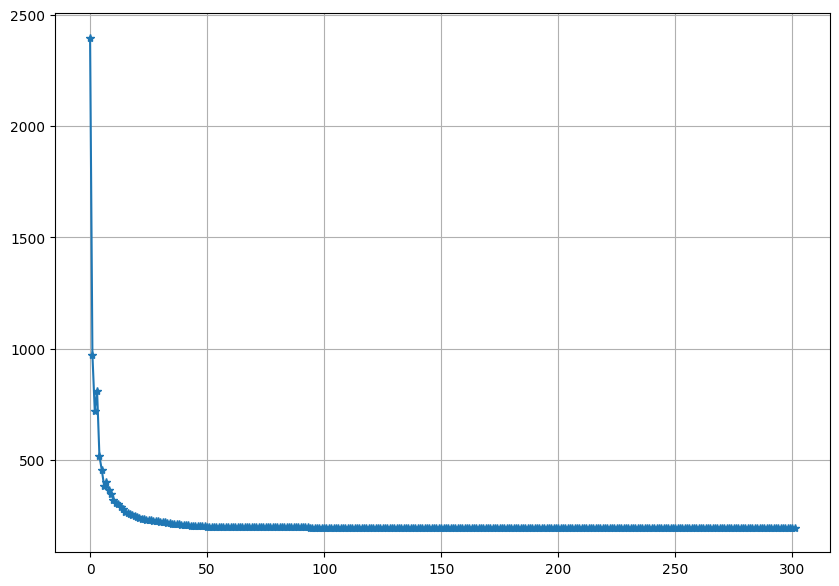

In [7]:
# Plot the loss
ax = best_trial[1].plot(figsize=(10, 7), marker='*')
ax.grid()

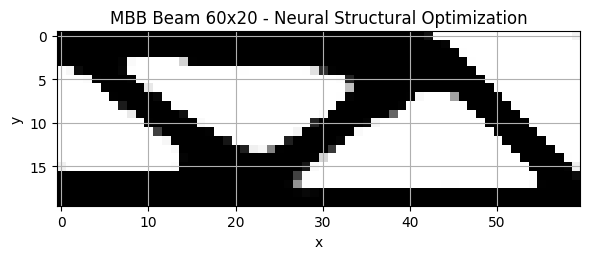

In [8]:
from scipy.ndimage import gaussian_filter

pygranso_structure = best_trial[2][-1].detach().numpy()

# Plot the two structures together
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

# pygranso
ax1.imshow(pygranso_structure, cmap='Greys')
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('MBB Beam 60x20 - Neural Structural Optimization')
fig.tight_layout()